#Imports and setups

In [1]:
!pip install -q sentence-transformers scikit-learn pandas numpy

In [22]:
import pandas as pd
import numpy as np
import sklearn
import sentence_transformers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score


from sentence_transformers import SentenceTransformer

Version

In [23]:
print("sklearn:", sklearn.__version__)
print("sentence-transformers:", sentence_transformers.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

sklearn: 1.6.1
sentence-transformers: 5.2.0
pandas: 2.2.2
numpy: 2.0.2


#Load dataset

In [31]:
df = pd.read_csv(
    "dataset.csv",
    sep=";",
    encoding="latin-1"
)
def clean_text(text):
    if isinstance(text, str):
        text = text.encode("latin-1").decode("utf-8", errors="ignore")
        text = text.replace("Õ", "'")
        text = text.replace("Ê", " ")
    return text

df["sentence_1"] = df["sentence_1"].apply(clean_text)
df["sentence_2"] = df["sentence_2"].apply(clean_text)

df.head(20)

,id,sentence_1,sentence_2,label
0,1,The company reduced its workforce last year.,The firm laid off employees during the previou...,1
1,2,The satellite entered a stable orbit.,The spacecraft successfully reached a stable o...,1
2,3,"Color is highly subjective, but has observable...","Color perception is subjective, yet it produce...",1
3,4,It took him a month to finish the meal.,He needed an entire month to complete the meal.,1
4,5,He enjoys practicing his ballet in the bathroom,The man likes to rehearse ballet exercises in ...,1
5,6,"Everyone was busy, so I went to the movie alone.","Since no one was available, I ended up watchin...",1
6,7,Nobody questions who built the pyramids in Mex...,No one doubts the identity of the builders of ...,1
7,8,The Japanese yen for commerce is still well-kn...,The Japanese yen remains widely recognized in ...,1
8,9,Changes in female dress standards and acceptab...,Feminist movements have also influenced clothi...,1
9,10,Music often plays a key role in social events ...,Music frequently serves an important function ...,1


#TF-IDF vectorization + cosine similarity

In [32]:
sentences = pd.concat([df["sentence_1"], df["sentence_2"]])

vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 1)
)

tfidf_vectors = vectorizer.fit_transform(sentences)

Separate the vectors into pairs

In [33]:
n = len(df)

tfidf_vec_1 = tfidf_vectors[:n]
tfidf_vec_2 = tfidf_vectors[n:]


Calculating cosine similarity

In [34]:
tfidf_similarities = cosine_similarity(tfidf_vec_1, tfidf_vec_2).diagonal()

df["tfidf_similarity"] = tfidf_similarities

#Sentence-BERT embeddings + cosine similarity

In [37]:
model = SentenceTransformer("all-MiniLM-L6-v2")

Generate the embeddings

In [38]:
embeddings_1 = model.encode(
    df["sentence_1"].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

embeddings_2 = model.encode(
    df["sentence_2"].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Cosine Similarity SBERT

In [39]:
sbert_similarities = cosine_similarity(embeddings_1, embeddings_2).diagonal()

df["sbert_similarity"] = sbert_similarities


#Comparison of results

In [40]:
df[["label", "tfidf_similarity", "sbert_similarity"]].head(100)

,label,tfidf_similarity,sbert_similarity
0,1,0.202153,0.647431
1,1,0.187846,0.711152
2,1,0.462190,0.902612
3,1,0.410664,0.857885
4,1,0.377680,0.834975
...,...,...,...
95,0,0.000000,0.025016
96,0,0.000000,-0.069192
97,0,0.000000,-0.034419
98,0,0.000000,-0.085143


In [41]:
def evaluate_model(similarities, labels, threshold):
    predictions = (similarities >= threshold).astype(int)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)

    return accuracy, precision, recall

Evaluation TF-IDF

In [42]:
thresholds = [0.6, 0.7, 0.8]

for t in thresholds:
    acc, prec, rec = evaluate_model(
        df["tfidf_similarity"].values,
        df["label"].values,
        t
    )
    print(f"TF-IDF | Threshold={t} | Accuracy={acc:.2f} | Precision={prec:.2f} | Recall={rec:.2f}")


TF-IDF | Threshold=0.6 | Accuracy=0.54 | Precision=1.00 | Recall=0.06
TF-IDF | Threshold=0.7 | Accuracy=0.51 | Precision=0.00 | Recall=0.00
TF-IDF | Threshold=0.8 | Accuracy=0.51 | Precision=0.00 | Recall=0.00


Evaluation SBERT

In [43]:
for t in thresholds:
    acc, prec, rec = evaluate_model(
        df["sbert_similarity"].values,
        df["label"].values,
        t
    )
    print(f"SBERT | Threshold={t} | Accuracy={acc:.2f} | Precision={prec:.2f} | Recall={rec:.2f}")


SBERT | Threshold=0.6 | Accuracy=0.96 | Precision=1.00 | Recall=0.92
SBERT | Threshold=0.7 | Accuracy=0.93 | Precision=1.00 | Recall=0.86
SBERT | Threshold=0.8 | Accuracy=0.83 | Precision=1.00 | Recall=0.65


In [44]:
print("TF-IDF")
print("Positive pairs:", df[df.label == 1]["tfidf_similarity"].mean())
print("Negative pairs:", df[df.label == 0]["tfidf_similarity"].mean())


TF-IDF
Positive pairs: 0.3128682346755174
Negative pairs: 0.0


In [45]:
print("SBERT")
print("Positive pairs:", df[df.label == 1]["sbert_similarity"].mean())
print("Negative pairs:", df[df.label == 0]["sbert_similarity"].mean())


SBERT
Positive pairs: 0.79752964
Negative pairs: -0.008605315


TF-IDF Error Analysis

In [46]:
threshold = 0.7
df["tfidf_pred"] = (df["tfidf_similarity"] >= threshold).astype(int)

tfidf_errors = df[df["tfidf_pred"] != df["label"]]
tfidf_errors.head(10)


,id,sentence_1,sentence_2,label,tfidf_similarity,sbert_similarity,tfidf_pred
0,1,The company reduced its workforce last year.,The firm laid off employees during the previou...,1,0.202153,0.647431,0
1,2,The satellite entered a stable orbit.,The spacecraft successfully reached a stable o...,1,0.187846,0.711152,0
2,3,"Color is highly subjective, but has observable...","Color perception is subjective, yet it produce...",1,0.462190,0.902612,0
3,4,It took him a month to finish the meal.,He needed an entire month to complete the meal.,1,0.410664,0.857885,0
4,5,He enjoys practicing his ballet in the bathroom,The man likes to rehearse ballet exercises in ...,1,0.377680,0.834975,0
5,6,"Everyone was busy, so I went to the movie alone.","Since no one was available, I ended up watchin...",1,0.247158,0.721188,0
6,7,Nobody questions who built the pyramids in Mex...,No one doubts the identity of the builders of ...,1,0.198683,0.793442,0
7,8,The Japanese yen for commerce is still well-kn...,The Japanese yen remains widely recognized in ...,1,0.364947,0.825947,0
8,9,Changes in female dress standards and acceptab...,Feminist movements have also influenced clothi...,1,0.384127,0.864729,0
9,10,Music often plays a key role in social events ...,Music frequently serves an important function ...,1,0.207164,0.840894,0


SBERT Error Analysis

In [47]:
df["sbert_pred"] = (df["sbert_similarity"] >= threshold).astype(int)

sbert_errors = df[df["sbert_pred"] != df["label"]]
sbert_errors.head(10)


,id,sentence_1,sentence_2,label,tfidf_similarity,sbert_similarity,tfidf_pred,sbert_pred
0,1,The company reduced its workforce last year.,The firm laid off employees during the previou...,1,0.202153,0.647431,0,0
13,14,Most of Earth's land is at least somewhathumid...,A large portion of Earths land surface is mode...,1,0.129576,0.686811,0,0
22,23,A hierarchy is typically depicted as apyramid,Hierarchical structures are commonly represent...,1,0.000000,0.574730,0,0
28,29,Aseais a largebodyofsalt water.,A sea is an extensive mass of saline water.,1,0.211437,0.459909,0,0
29,30,Anemployeecontributes labour and expertise to ...,An employee provides skills and effort to supp...,1,0.000000,0.483484,0,0
36,37,The question of whether lies can be detected r...,Researchers have frequently examined whether d...,1,0.114247,0.652576,0,0
41,42,Atransgenderperson has agender identitydiffere...,A person who identifies as transgender has a g...,1,0.096757,0.517642,0,0


TF-IDF – Similarity histogram



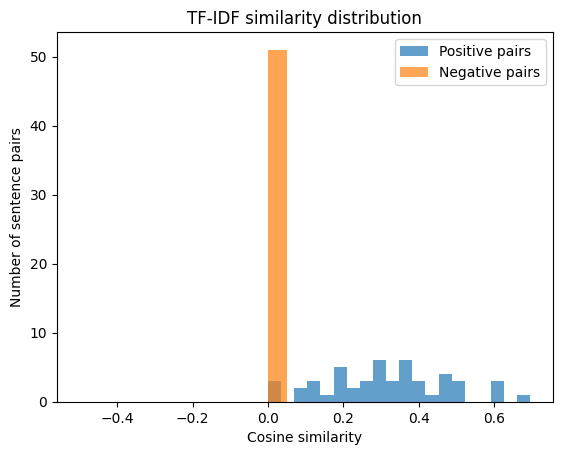

In [49]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df[df.label == 1]["tfidf_similarity"], bins=20, alpha=0.7, label="Positive pairs")
plt.hist(df[df.label == 0]["tfidf_similarity"], bins=20, alpha=0.7, label="Negative pairs")
plt.xlabel("Cosine similarity")
plt.ylabel("Number of sentence pairs")
plt.title("TF-IDF similarity distribution")
plt.legend()
plt.show()

SBERT – Similarity histogram


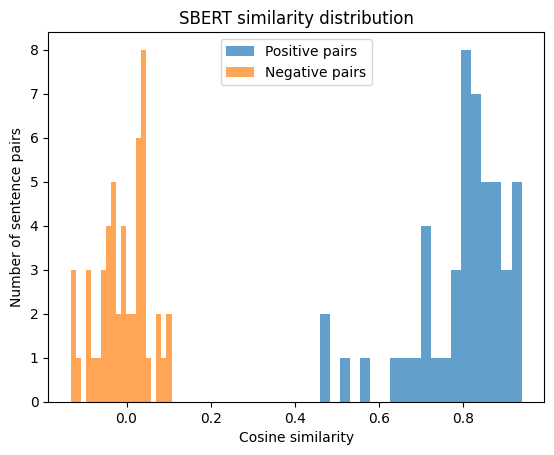

In [50]:
plt.figure()
plt.hist(df[df.label == 1]["sbert_similarity"], bins=20, alpha=0.7, label="Positive pairs")
plt.hist(df[df.label == 0]["sbert_similarity"], bins=20, alpha=0.7, label="Negative pairs")
plt.xlabel("Cosine similarity")
plt.ylabel("Number of sentence pairs")
plt.title("SBERT similarity distribution")
plt.legend()
plt.show()

Accuracy as a function of the threshold

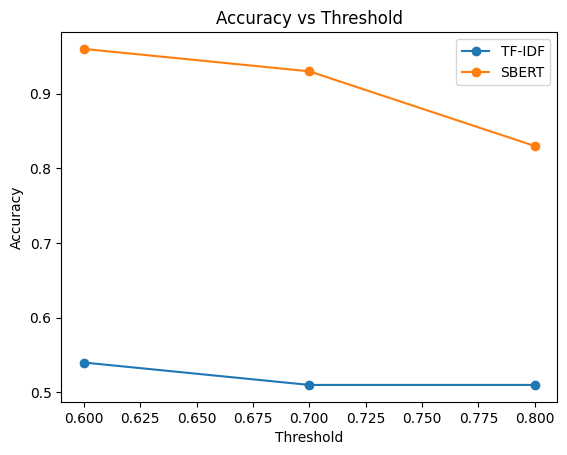

In [51]:
thresholds = [0.6, 0.7, 0.8]

tfidf_acc = []
sbert_acc = []

for t in thresholds:
    tfidf_acc.append(
        evaluate_model(df["tfidf_similarity"], df["label"], t)[0]
    )
    sbert_acc.append(
        evaluate_model(df["sbert_similarity"], df["label"], t)[0]
    )

plt.figure()
plt.plot(thresholds, tfidf_acc, marker='o', label="TF-IDF")
plt.plot(thresholds, sbert_acc, marker='o', label="SBERT")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.legend()
plt.show()


Precision / Recall trade-off (SBERT)

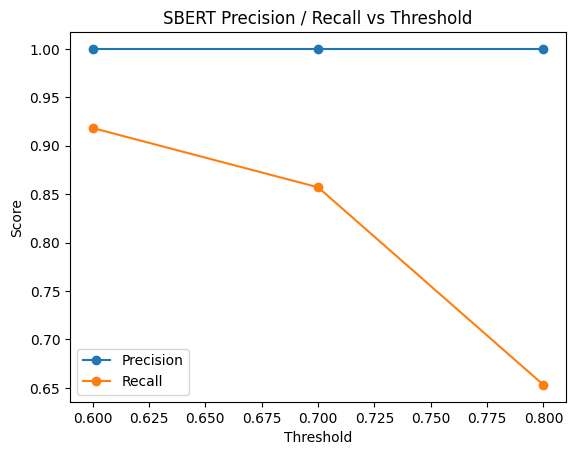

In [52]:
precisions = []
recalls = []

for t in thresholds:
    _, p, r = evaluate_model(df["sbert_similarity"], df["label"], t)
    precisions.append(p)
    recalls.append(r)

plt.figure()
plt.plot(thresholds, precisions, marker='o', label="Precision")
plt.plot(thresholds, recalls, marker='o', label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("SBERT Precision / Recall vs Threshold")
plt.legend()
plt.show()
